In [192]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=28
import numba as nb
from numba.types import *
from numba import prange
from scipy.linalg import expm

In [223]:
p= np.pi/2
k=5
#k=2 should be mostly regular, 2.5 mixed behaviour, 3 mostly chaotic, 6 fully chaotic
N_points=300 #Number of random initial pairs of points to average (d(t) plot) or number of initial points (X-Z plots)
N_steps=300 #Number of time steps
S=9
dim=int(2*S+1)

In [123]:
@nb.njit()
def Map(X, Y, Z, p, k):
    i=complex(0,1)
    aux=(X*np.cos(p)+ Z*np.sin(p)+ i*Y)*np.exp(i*k*(Z*np.cos(p)-X*np.sin(p)))
    X_=np.real(aux)
    Y_=np.imag(aux)
    Z_=-X*np.sin(p)+ Z*np.cos(p)
    return (X_, Y_, Z_)

In [124]:
@nb.njit()
def Generate_Rand(N_points):
    #Generate random points uniformly on a sphere. 
    #Let a, b be two uniform random numbers on [0,1] then the azimuthal 
    #and polar angles are given by ϕ=2πa, θ=arccos(1-2b)
    a=np.random.rand(N_points)
    b=np.random.rand(N_points)
    ϕ=2*np.pi*a
    θ=np.arccos(1-2*b)
    X=np.sin(θ)*np.cos(ϕ)
    Y=np.sin(θ)*np.sin(ϕ)
    Z=np.cos(θ)
    return (X, Y, Z)

In [125]:
#@nb.njit()
def Generate_Close(epsilon):
    a=np.random.rand(1)
    b=np.random.rand(1)
    c=np.random.rand(1)-0.5
    d=np.random.rand(1)-0.5
    ϕ=2*np.pi*a
    θ=np.arccos(1-2*b)
    X_=np.zeros(2)
    Y_=np.zeros(2)
    Z_=np.zeros(2)
    X_[0]=np.sin(θ)*np.cos(ϕ)
    Y_[0]=np.sin(θ)*np.sin(ϕ)
    Z_[0]=np.cos(θ)   
    X_[1]=np.sin(θ+epsilon*c)*np.cos(ϕ+epsilon*d)
    Y_[1]=np.sin(θ+epsilon*c)*np.sin(ϕ+epsilon*d)
    Z_[1]=np.cos(θ+epsilon*c) 
    return (X_, Y_, Z_)

In [126]:
@nb.njit()
def Trajectory(N_p, N_t, p, k):
    X_=np.zeros((N_p,N_t))
    Y_=np.zeros((N_p,N_t))
    Z_=np.zeros((N_p,N_t))
    X0, Y0, Z0=Generate_Rand(N_p)
    X_[:,0]=X0
    Y_[:,0]=Y0
    Z_[:,0]=Z0
    for j in range(1, N_t):
        X, Y, Z=Map(X0, Y0, Z0, p,k)
        X_[:,j]=X
        Y_[:,j]=Y
        Z_[:,j]=Z
        X0=X
        Y0=Y
        Z0=Z
    Xout=X_.flatten()
    Yout=Y_.flatten()
    Zout=Z_.flatten()
    return (Xout, Yout, Zout)

In [127]:
#@nb.njit()
def DivergClose(N_t, p, k):
    X_c=np.zeros((2,N_t))
    Y_c=np.zeros((2,N_t))
    Z_c=np.zeros((2,N_t))
    X0, Y0, Z0=Generate_Close(1e-12)
    X_c[:,0]=X0
    Y_c[:,0]=Y0
    Z_c[:,0]=Z0
    for j in range(1, N_t):
        X, Y, Z=Map(X0, Y0, Z0, p,k)
        X_c[:,j]=X
        Y_c[:,j]=Y
        Z_c[:,j]=Z
        X0=X
        Y0=Y
        Z0=Z
    return (X_c[0, :], Y_c[0, :], Z_c[0, :], X_c[1, :], Y_c[1, :], Z_c[1, :])

In [128]:
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype='int64')

@nb.jit(float64(int64), nopython=True, fastmath=True, parallel=False)
def fast_log_factorial(n):
    if n<20:
        return np.log(LOOKUP_TABLE[n])
    else:
        #stirling approx
        return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)
        #return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)+ 1/(12*n)-1/(360*n**3)
#Take into account that z is complex
@nb.jit(complex128[:](float64, complex128), nopython=True, fastmath=True, parallel=False)
def define_zeta(S, z):
    dim=int(2*S+1)
    ket_z=np.zeros(dim, dtype=complex128)
    for l in range(dim):
        m=l-S
        aux1=fast_log_factorial(int(2*S)) #aux1= log((2S)!)
        aux2=fast_log_factorial(int(S+m)) #aux2= log((S+m)!)
        aux3=fast_log_factorial(int(S-m)) #aux3= log((S-m)!)
        #ket_z[j]=np.sqrt(aux1/(aux2*aux3))*z**(S+m)/(1 + (np.abs(z))**2)**S
        #To deal with big numbers we introduce the log 
        #of the factorial, compute the division of them and afterwards we exponentiate
        ket_z[l]=np.exp((aux1-aux2-aux3)/2)*z**(S+m)/((1 + (np.abs(z))**2)**S) 
    norm= np.sqrt(np.conjugate(ket_z)@ket_z)
    return ket_z/norm

In [129]:
@nb.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
#Definition of the ladder operators
@nb.jit(nb.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@nb.jit(nb.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)
@nb.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for m in range(dim):
            ket=basis[j, :]
            bra=basis[m, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, m]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@nb.jit(complex128[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for m in range(dim):
            ket=basis[j, :]
            bra=basis[m, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, m]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@nb.jit(float64[:,:](float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz

In [130]:
@nb.njit()
def Fidelity(N_steps, U, z):
    Uloop=np.zeros((dim, dim), dtype=complex128)
    for l in range(dim):
        Uloop[l,l]=1
    coh_state=define_zeta(S,z)
    F=np.zeros(N_steps)
    for j in range(N_steps):
        
        F[j]=(np.abs(np.conjugate(coh_state)@Uloop@coh_state))**2
        Uloop=Uloop@U
    return  F

In [224]:
Xp, Yp, Zp=Trajectory(N_points, N_steps, p, k)

In [225]:
#Xc, Yc, Zc, Xd, Yd, Zd=DivergClose(200, p, k)

In [226]:
θ_coh=0.8
ϕ_coh=np.pi/2
i=complex(0,1)
basis = np.identity(dim)
z=np.exp(i*ϕ_coh)*np.tan(θ_coh/2)
Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)
U=expm(-i*k*Sz@Sz/(2*S))@expm(-i*p*Sy)
ntF=100
F=Fidelity(ntF, U, z)

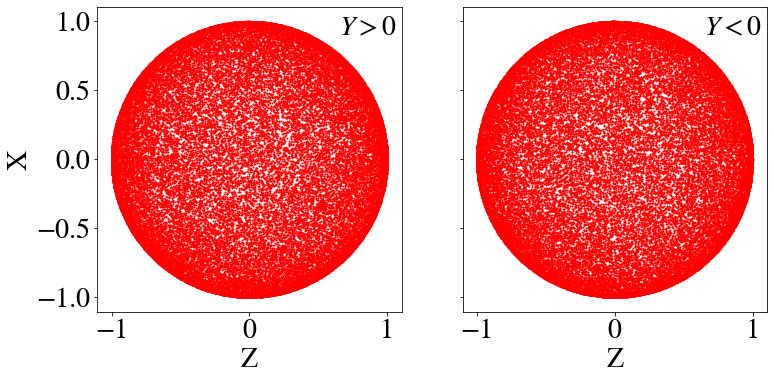

In [227]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[12, 6])
#ax=fig.add_subplot(111)
ax1.scatter(Zp[Yp>0], Xp[Yp>0], s=1, color='red')
ax2.scatter(Zp[Yp<0], Xp[Yp<0], s=1, color='red')
#ax1.scatter(Zc[Yc>0], Xc[Yc>0], s=1, color='black')
#ax2.scatter(Zc[Yc<0], Xc[Yc<0], s=1, color='black')
#ax1.scatter(Zd[Yd>0], Xd[Yd>0], s=1, color='blue')
#ax2.scatter(Zd[Yd<0], Xd[Yd<0], s=1, color='blue')

ax1.set_xlabel("Z")
ax2.set_xlabel("Z")
ax1.set_ylabel("X")
ax1.axis('square')
ax2.axis('square')
ax1.text(0.65, 0.9, r"$Y>0$")
ax2.text(0.65, 0.9, r"$Y<0$")
plt.show()

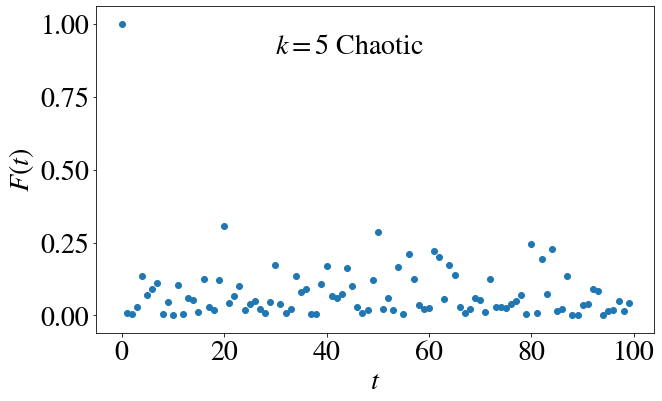

In [229]:
t=np.arange(0, ntF, 1)
plt.figure(figsize=[10,6])
plt.scatter(t, F)
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.text(30, 0.9, "$k=5$ Chaotic")
plt.show()